### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
# State-action pairs to be tracked
env1 = CabDriver()
states_tracked = [[],[],[],[]]
states_to_be_tracked = [(np.array(env1.state_encod_arch1((0,0,0))).reshape(1, 36), (2, 4), (0,0,0)), (np.array(env1.state_encod_arch1((3,10,3))).reshape(1, 36), (0,0), (3,10,3)), (np.array(env1.state_encod_arch1((1,5,6))).reshape(1, 36), (1,4), (1,5,6)), (np.array(env1.state_encod_arch1((1, 23, 2))).reshape(1, 36), (4,0), (1,23,2))]

In [4]:
#Rewards to be saved in each episode
episode_reward_track = []

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate =  0.001      
        self.epsilon_max = 1.0
        self.epsilon = 1.0
        self.epsilon_decay = -0.00008
        self.epsilon_min = 0.001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform')) 
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_idx):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment   
        if np.random.rand() > self.epsilon:
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
            q_values_allowed = [q_value[0][i] for i in possible_actions_idx]
            action = possible_actions_idx[np.argmax(q_values_allowed)] #Exploitation: this gets the action corresponding to max q-value of current state 
        else:
            action = random.choice(possible_actions_idx) #Exploration: randomly choosing and action

        return action
    
    def updateEpsilon(self, episode):
        self.epsilon = (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * episode)
    
    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            action, reward, done = [], [], []
            
            for i in range(self.batch_size):
                state_batch, action_batch, reward_batch, next_state, done_bool = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state_batch)
                action.append(action_batch)
                reward.append(reward_batch)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_bool)
                
            # Write your code from here
            
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            target_val = self.model.predict(update_output)
                
            # 2. Get the target for the Q-network
            for i in range(self.batch_size):
                if done[i]: # terminal state
                    target[i][action[i]] = reward[i]
                else: # non-terminal state
                    target[i][action[i]] = reward[i] + self.discount_factor * np.max(target_val[i])

                
            # 3. Fit your model
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        self.model.save(name)
        
    def save_tracking_states(self, action_space):
    # Use the model to predict the q_value of the state we are tacking.
        i = 0;
        for s in states_to_be_tracked:
            action_idx = action_space.index(s[1])
            q_value = self.model.predict(s[0])
            states_tracked[i].append(q_value[0][action_idx])
            i+=1

In [7]:
Episodes = 30000
Episode_len = 30*24 #30 days  X 24 hours
threshold = 10 #Q-value for states being tracked & rewards per episode will be saved after these many episodes 

### DQN block

In [8]:
# Call the environment and initialised variables of the environment
env = CabDriver()
action_space, state_space, state = env.reset()
    
state_size = 36 #5+24+7
action_size = len(action_space)
#Call the DQN agent
agent = DQNAgent(state_size, action_size)

for episode in range(Episodes):

    terminal_state = False
    # Write code here
    # Initialised variables of the environment
    action_space, state_space, state = env.reset()
    
    episode_time = 0
    episode_reward = 0
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_idxs, actions = env.requests(state)
        action = agent.get_action(state, possible_actions_idxs)
        
        # 2. Evaluate your reward and next state
        next_state, reward, time_taken = env.step(state, env.action_space[action], Time_matrix)
        episode_time = episode_time + time_taken
        if(episode_time > Episode_len):
            terminal_state = True
            continue

        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, terminal_state)

        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        # 5. Keep a track of rewards, Q-values, loss
        state = next_state
        episode_reward = episode_reward + reward
    
    #update epsilon after each episode
    agent.updateEpsilon(episode)
    
    #track states
    if ((episode + 1) % threshold == 0):
        agent.save_tracking_states(action_space)
        episode_reward_track.append(episode_reward)
        print("episode {0}, reward {1}, epsilon {2}".format(episode, episode_reward, agent.epsilon))
    
    
    if(episode % 1000 == 0):
        agent.save(name="DQN_weights.pkl")


episode 9, reward 19.0, epsilon 0.9982809788786654
episode 19, reward 146.0, epsilon 0.9974826734603062
episode 29, reward -297.0, epsilon 0.9966850064308919
episode 39, reward -319.0, epsilon 0.9958879772799157
episode 49, reward -133.0, epsilon 0.995091585497279
episode 59, reward -161.0, epsilon 0.9942958305732912
episode 69, reward -175.0, epsilon 0.9935007119986687
episode 79, reward -94.0, epsilon 0.9927062292645358
episode 89, reward 91.0, epsilon 0.9919123818624236
episode 99, reward -98.0, epsilon 0.9911191692842695
episode 109, reward 36.0, epsilon 0.9903265910224177
episode 119, reward -74.0, epsilon 0.989534646569618
episode 129, reward -51.0, epsilon 0.9887433354190258
episode 139, reward -186.0, epsilon 0.9879526570642019
episode 149, reward 8.0, epsilon 0.9871626109991124
episode 159, reward -107.0, epsilon 0.9863731967181276
episode 169, reward -4.0, epsilon 0.9855844137160225
episode 179, reward 54.0, epsilon 0.9847962614879756
episode 189, reward -130.0, epsilon 0.984

episode 1519, reward 27.0, epsilon 0.8846877683632125
episode 1529, reward -160.0, epsilon 0.8839803011731295
episode 1539, reward 86.0, epsilon 0.8832733997304695
episode 1549, reward 143.0, epsilon 0.8825670635828154
episode 1559, reward -261.0, epsilon 0.8818612922781123
episode 1569, reward -54.0, epsilon 0.881156085364666
episode 1579, reward 19.0, epsilon 0.8804514423911447
episode 1589, reward 108.0, epsilon 0.8797473629065766
episode 1599, reward 69.0, epsilon 0.8790438464603507
episode 1609, reward 150.0, epsilon 0.8783408926022166
episode 1619, reward 151.0, epsilon 0.8776385008822836
episode 1629, reward 252.0, epsilon 0.8769366708510213
episode 1639, reward 189.0, epsilon 0.8762354020592582
episode 1649, reward 150.0, epsilon 0.8755346940581823
episode 1659, reward 108.0, epsilon 0.8748345463993404
episode 1669, reward 253.0, epsilon 0.8741349586346382
episode 1679, reward 73.0, epsilon 0.8734359303163394
episode 1689, reward 239.0, epsilon 0.8727374609970656
episode 1699, 

episode 3019, reward 91.0, epsilon 0.7846476618750279
episode 3029, reward 358.0, epsilon 0.7840201947658364
episode 3039, reward 308.0, epsilon 0.7833932294295964
episode 3049, reward 239.0, epsilon 0.78276676546505
episode 3059, reward 325.0, epsilon 0.7821408024712602
episode 3069, reward 7.0, epsilon 0.7815153400476106
episode 3079, reward 133.0, epsilon 0.7808903777938053
episode 3089, reward 369.0, epsilon 0.7802659153098686
episode 3099, reward 250.0, epsilon 0.7796419521961442
episode 3109, reward -56.0, epsilon 0.7790184880532958
episode 3119, reward 154.0, epsilon 0.7783955224823065
episode 3129, reward -21.0, epsilon 0.7777730550844779
episode 3139, reward 333.0, epsilon 0.7771510854614313
episode 3149, reward 123.0, epsilon 0.7765296132151059
episode 3159, reward 100.0, epsilon 0.7759086379477594
episode 3169, reward 315.0, epsilon 0.7752881592619678
episode 3179, reward 309.0, epsilon 0.7746681767606245
episode 3189, reward -90.0, epsilon 0.7740486900469407
episode 3199, r

episode 4519, reward 528.0, epsilon 0.6959200469392963
episode 4529, reward 547.0, epsilon 0.6953635335367866
episode 4539, reward 312.0, epsilon 0.694807465166962
episode 4549, reward 405.0, epsilon 0.6942518414739389
episode 4559, reward 163.0, epsilon 0.6936966621021181
episode 4569, reward 654.0, epsilon 0.6931419266961847
episode 4579, reward -77.0, epsilon 0.692587634901108
episode 4589, reward 150.0, epsilon 0.6920337863621413
episode 4599, reward 180.0, epsilon 0.6914803807248214
episode 4609, reward 320.0, epsilon 0.6909274176349689
episode 4619, reward 225.0, epsilon 0.6903748967386872
episode 4629, reward 184.0, epsilon 0.6898228176823631
episode 4639, reward 174.0, epsilon 0.6892711801126656
episode 4649, reward 280.0, epsilon 0.6887199836765472
episode 4659, reward 523.0, epsilon 0.6881692280212417
episode 4669, reward 560.0, epsilon 0.6876189127942657
episode 4679, reward 297.0, epsilon 0.6870690376434172
episode 4689, reward 351.0, epsilon 0.6865196022167763
episode 4699

episode 6019, reward 241.0, epsilon 0.6172257119516255
episode 6029, reward 93.0, epsilon 0.6167321288416325
episode 6039, reward 638.0, epsilon 0.6162389404402231
episode 6049, reward 469.0, epsilon 0.6157461464317567
episode 6059, reward 689.0, epsilon 0.6152537465008451
episode 6069, reward 447.0, epsilon 0.614761740332352
episode 6079, reward 368.0, epsilon 0.614270127611394
episode 6089, reward 401.0, epsilon 0.6137789080233385
episode 6099, reward 294.0, epsilon 0.613288081253805
episode 6109, reward 304.0, epsilon 0.6127976469886645
episode 6119, reward 328.0, epsilon 0.6123076049140389
episode 6129, reward 469.0, epsilon 0.6118179547163015
episode 6139, reward 599.0, epsilon 0.611328696082076
episode 6149, reward 95.0, epsilon 0.6108398286982368
episode 6159, reward 297.0, epsilon 0.6103513522519087
episode 6169, reward 551.0, epsilon 0.6098632664304671
episode 6179, reward 574.0, epsilon 0.6093755709215366
episode 6189, reward 344.0, epsilon 0.6088882654129925
episode 6199, re

episode 7519, reward 420.0, epsilon 0.547430097997194
episode 7529, reward 368.0, epsilon 0.546992329049723
episode 7539, reward 541.0, epsilon 0.5465549101773611
episode 7549, reward 456.0, epsilon 0.5461178411001605
episode 7559, reward 522.0, epsilon 0.5456811215383968
episode 7569, reward 576.0, epsilon 0.5452447512125695
episode 7579, reward 347.0, epsilon 0.5448087298434016
episode 7589, reward 585.0, epsilon 0.5443730571518393
episode 7599, reward 560.0, epsilon 0.5439377328590523
episode 7609, reward 464.0, epsilon 0.5435027566864328
episode 7619, reward 569.0, epsilon 0.5430681283555963
episode 7629, reward 395.0, epsilon 0.5426338475883802
episode 7639, reward 788.0, epsilon 0.5421999141068453
episode 7649, reward 721.0, epsilon 0.5417663276332738
episode 7659, reward 731.0, epsilon 0.5413330878901705
episode 7669, reward 559.0, epsilon 0.5409001946002621
episode 7679, reward 497.0, epsilon 0.5404676474864966
episode 7689, reward 671.0, epsilon 0.5400354462720439
episode 7699

episode 9009, reward 457.0, epsilon 0.48591551855111914
episode 9019, reward 905.0, epsilon 0.4855269415877877
episode 9029, reward 704.0, epsilon 0.48513867536171545
episode 9039, reward 419.0, epsilon 0.48475071962441196
episode 9049, reward 1005.0, epsilon 0.4843630741275856
episode 9059, reward 740.0, epsilon 0.4839757386231432
episode 9069, reward 371.0, epsilon 0.48358871286319005
episode 9079, reward 29.0, epsilon 0.4832019966000296
episode 9089, reward 498.0, epsilon 0.4828155895861635
episode 9099, reward 413.0, epsilon 0.4824294915742912
episode 9109, reward 545.0, epsilon 0.48204370231731003
episode 9119, reward 595.0, epsilon 0.4816582215683147
episode 9129, reward 526.0, epsilon 0.4812730490805977
episode 9139, reward 756.0, epsilon 0.48088818460764843
episode 9149, reward 460.0, epsilon 0.4805036279031539
episode 9159, reward 816.0, epsilon 0.4801193787209975
episode 9169, reward 266.0, epsilon 0.4797354368152599
episode 9179, reward 788.0, epsilon 0.4793518019402182
epis

episode 10479, reward 376.0, epsilon 0.4320039702729636
episode 10489, reward 915.0, epsilon 0.43165850530115873
episode 10499, reward 693.0, epsilon 0.43131331659081207
episode 10509, reward 772.0, epsilon 0.43096840392100266
episode 10519, reward 808.0, epsilon 0.4306237670709865
episode 10529, reward 639.0, epsilon 0.4302794058201959
episode 10539, reward 424.0, epsilon 0.4299353199482398
episode 10549, reward 594.0, epsilon 0.42959150923490314
episode 10559, reward 549.0, epsilon 0.4292479734601471
episode 10569, reward 833.0, epsilon 0.4289047124041086
episode 10579, reward 630.0, epsilon 0.4285617258471007
episode 10589, reward 794.0, epsilon 0.428219013569612
episode 10599, reward 640.0, epsilon 0.4278765753523066
episode 10609, reward 500.0, epsilon 0.42753441097602407
episode 10619, reward 434.0, epsilon 0.4271925202217791
episode 10629, reward 961.0, epsilon 0.42685090287076166
episode 10639, reward 1013.0, epsilon 0.42650955870433666
episode 10649, reward 827.0, epsilon 0.42

episode 11929, reward 774.0, epsilon 0.384688831894212
episode 11939, reward 981.0, epsilon 0.3843812038963026
episode 11949, reward 491.0, epsilon 0.3840738219023768
episode 11959, reward 1015.0, epsilon 0.3837666857157102
episode 11969, reward 890.0, epsilon 0.38345979513973555
episode 11979, reward 779.0, epsilon 0.38315314997804284
episode 11989, reward 992.0, epsilon 0.3828467500343792
episode 11999, reward 843.0, epsilon 0.3825405951126486
episode 12009, reward 784.0, epsilon 0.382234685016912
episode 12019, reward 977.0, epsilon 0.38192901955138686
episode 12029, reward 692.0, epsilon 0.38162359852044725
episode 12039, reward 765.0, epsilon 0.38131842172862374
episode 12049, reward 1060.0, epsilon 0.3810134889806031
episode 12059, reward 835.0, epsilon 0.3807088000812284
episode 12069, reward 996.0, epsilon 0.38040435483549884
episode 12079, reward 767.0, epsilon 0.3801001530485693
episode 12089, reward 920.0, epsilon 0.3797961945257507
episode 12099, reward 820.0, epsilon 0.379

episode 13379, reward 873.0, epsilon 0.3425558734810423
episode 13389, reward 889.0, epsilon 0.3422819383709114
episode 13399, reward 705.0, epsilon 0.3420082223212328
episode 13409, reward 716.0, epsilon 0.341734725156828
episode 13419, reward 889.0, epsilon 0.3414614467026591
episode 13429, reward 1224.0, epsilon 0.3411883867838276
episode 13439, reward 1359.0, epsilon 0.34091554522557543
episode 13449, reward 1167.0, epsilon 0.3406429218532839
episode 13459, reward 1050.0, epsilon 0.34037051649247385
episode 13469, reward 1123.0, epsilon 0.340098328968806
episode 13479, reward 720.0, epsilon 0.33982635910808023
episode 13489, reward 1225.0, epsilon 0.33955460673623605
episode 13499, reward 1121.0, epsilon 0.3392830716793517
episode 13509, reward 950.0, epsilon 0.33901175376364473
episode 13519, reward 923.0, epsilon 0.33874065281547183
episode 13529, reward 1013.0, epsilon 0.3384697686613282
episode 13539, reward 809.0, epsilon 0.3381991011278482
episode 13549, reward 756.0, epsilon

episode 14819, reward 1163.0, epsilon 0.30528164558227666
episode 14829, reward 1017.0, epsilon 0.3050375179298919
episode 14839, reward 1223.0, epsilon 0.3047935855015291
episode 14849, reward 1156.0, epsilon 0.3045498481410714
episode 14859, reward 810.0, epsilon 0.30430630569252687
episode 14869, reward 1231.0, epsilon 0.30406295800002836
episode 14879, reward 1088.0, epsilon 0.30381980490783345
episode 14889, reward 1337.0, epsilon 0.3035768462603239
episode 14899, reward 1081.0, epsilon 0.30333408190200645
episode 14909, reward 1184.0, epsilon 0.30309151167751175
episode 14919, reward 1239.0, epsilon 0.30284913543159475
episode 14929, reward 1062.0, epsilon 0.3026069530091349
episode 14939, reward 855.0, epsilon 0.30236496425513526
episode 14949, reward 1091.0, epsilon 0.302123169014723
episode 14959, reward 880.0, epsilon 0.3018815671331494
episode 14969, reward 1218.0, epsilon 0.3016401584557889
episode 14979, reward 981.0, epsilon 0.30139894282814017
episode 14989, reward 1294.

episode 16259, reward 1151.0, epsilon 0.2720633051255519
episode 16269, reward 1617.0, epsilon 0.2718457415184977
episode 16279, reward 1462.0, epsilon 0.2716283518927273
episode 16289, reward 1166.0, epsilon 0.27141113610911144
episode 16299, reward 756.0, epsilon 0.27119409402863187
episode 16309, reward 1031.0, epsilon 0.27097722551238185
episode 16319, reward 1263.0, epsilon 0.27076053042156534
episode 16329, reward 1260.0, epsilon 0.2705440086174975
episode 16339, reward 1455.0, epsilon 0.27032765996160446
episode 16349, reward 1280.0, epsilon 0.270111484315423
episode 16359, reward 1419.0, epsilon 0.2698954815406008
episode 16369, reward 1072.0, epsilon 0.26967965149889594
episode 16379, reward 1311.0, epsilon 0.2694639940521772
episode 16389, reward 902.0, epsilon 0.26924850906242387
episode 16399, reward 1246.0, epsilon 0.2690331963917255
episode 16409, reward 1315.0, epsilon 0.2688180559022821
episode 16419, reward 1105.0, epsilon 0.26860308745640366
episode 16429, reward 1466

episode 17699, reward 848.0, epsilon 0.2424595224343103
episode 17709, reward 1436.0, epsilon 0.24226563238272425
episode 17719, reward 1438.0, epsilon 0.24207189738115126
episode 17729, reward 1422.0, epsilon 0.24187831730560083
episode 17739, reward 1422.0, epsilon 0.2416848920321817
episode 17749, reward 1346.0, epsilon 0.2414916214371018
episode 17759, reward 1116.0, epsilon 0.24129850539666775
episode 17769, reward 973.0, epsilon 0.2411055437872855
episode 17779, reward 1438.0, epsilon 0.24091273648545947
episode 17789, reward 1269.0, epsilon 0.24072008336779296
episode 17799, reward 947.0, epsilon 0.24052758431098809
episode 17809, reward 1041.0, epsilon 0.24033523919184532
episode 17819, reward 1075.0, epsilon 0.24014304788726393
episode 17829, reward 1442.0, epsilon 0.23995101027424132
episode 17839, reward 1199.0, epsilon 0.23975912622987347
episode 17849, reward 1058.0, epsilon 0.23956739563135462
episode 17859, reward 1110.0, epsilon 0.2393758183559771
episode 17869, reward 

episode 19129, reward 1372.0, epsilon 0.21624992060092169
episode 19139, reward 1379.0, epsilon 0.21607698984596593
episode 19149, reward 1487.0, epsilon 0.21590419738029099
episode 19159, reward 1557.0, epsilon 0.2157315430933098
episode 19169, reward 1437.0, epsilon 0.2155590268745235
episode 19179, reward 1447.0, epsilon 0.2153866486135218
episode 19189, reward 1256.0, epsilon 0.21521440819998258
episode 19199, reward 1539.0, epsilon 0.2150423055236719
episode 19209, reward 1075.0, epsilon 0.21487034047444414
episode 19219, reward 1555.0, epsilon 0.21469851294224157
episode 19229, reward 1339.0, epsilon 0.21452682281709468
episode 19239, reward 1747.0, epsilon 0.2143552699891217
episode 19249, reward 1417.0, epsilon 0.21418385434852874
episode 19259, reward 1229.0, epsilon 0.21401257578560998
episode 19269, reward 905.0, epsilon 0.21384143419074697
episode 19279, reward 1350.0, epsilon 0.21367042945440917
episode 19289, reward 1515.0, epsilon 0.21349956146715351
episode 19299, rewar

episode 20559, reward 1259.0, epsilon 0.19287354726426448
episode 20569, reward 1417.0, epsilon 0.19271931012953294
episode 20579, reward 1189.0, epsilon 0.19256519633516642
episode 20589, reward 954.0, epsilon 0.1924112057825322
episode 20599, reward 1442.0, epsilon 0.19225733837307624
episode 20609, reward 1379.0, epsilon 0.19210359400832336
episode 20619, reward 1288.0, epsilon 0.19194997258987723
episode 20629, reward 1593.0, epsilon 0.1917964740194201
episode 20639, reward 1458.0, epsilon 0.1916430981987129
episode 20649, reward 1580.0, epsilon 0.19148984502959507
episode 20659, reward 1420.0, epsilon 0.1913367144139846
episode 20669, reward 1284.0, epsilon 0.1911837062538779
episode 20679, reward 1179.0, epsilon 0.1910308204513497
episode 20689, reward 1438.0, epsilon 0.19087805690855314
episode 20699, reward 1625.0, epsilon 0.19072541552771952
episode 20709, reward 1454.0, epsilon 0.1905728962111583
episode 20719, reward 1501.0, epsilon 0.1904204988612572
episode 20729, reward 1

episode 21989, reward 1577.0, epsilon 0.17202413360859242
episode 21999, reward 1080.0, epsilon 0.17188656933475188
episode 22009, reward 1229.0, epsilon 0.17174911506832158
episode 22019, reward 1723.0, epsilon 0.17161177072133071
episode 22029, reward 1660.0, epsilon 0.17147453620587902
episode 22039, reward 1442.0, epsilon 0.1713374114341363
episode 22049, reward 1391.0, epsilon 0.1712003963183428
episode 22059, reward 1605.0, epsilon 0.1710634907708088
episode 22069, reward 1782.0, epsilon 0.17092669470391467
episode 22079, reward 1341.0, epsilon 0.17079000803011102
episode 22089, reward 1481.0, epsilon 0.17065343066191832
episode 22099, reward 1479.0, epsilon 0.17051696251192708
episode 22109, reward 1341.0, epsilon 0.17038060349279768
episode 22119, reward 1323.0, epsilon 0.1702443535172603
episode 22129, reward 1805.0, epsilon 0.17010821249811503
episode 22139, reward 1239.0, epsilon 0.16997218034823153
episode 22149, reward 1201.0, epsilon 0.16983625698054927
episode 22159, rew

episode 23419, reward 1640.0, epsilon 0.15342851813287367
episode 23429, reward 1544.0, epsilon 0.1533058244024032
episode 23439, reward 1487.0, epsilon 0.15318322878766563
episode 23449, reward 1456.0, epsilon 0.15306073121019967
episode 23459, reward 1634.0, epsilon 0.15293833159160694
episode 23469, reward 1368.0, epsilon 0.15281602985355167
episode 23479, reward 1453.0, epsilon 0.15269382591776065
episode 23489, reward 1359.0, epsilon 0.15257171970602346
episode 23499, reward 1597.0, epsilon 0.1524497111401921
episode 23509, reward 1404.0, epsilon 0.15232780014218106
episode 23519, reward 1327.0, epsilon 0.15220598663396734
episode 23529, reward 1448.0, epsilon 0.15208427053759024
episode 23539, reward 1576.0, epsilon 0.15196265177515147
episode 23549, reward 1355.0, epsilon 0.15184113026881502
episode 23559, reward 1671.0, epsilon 0.15171970594080714
episode 23569, reward 1619.0, epsilon 0.15159837871341628
episode 23579, reward 1720.0, epsilon 0.15147714850899288
episode 23589, r

episode 24839, reward 1418.0, epsilon 0.13695258604297586
episode 24849, reward 1573.0, epsilon 0.13684306778728472
episode 24859, reward 1358.0, epsilon 0.13673363711116163
episode 24869, reward 1665.0, epsilon 0.13662429394457098
episode 24879, reward 1571.0, epsilon 0.13651503821753314
episode 24889, reward 1756.0, epsilon 0.13640586986012437
episode 24899, reward 1339.0, epsilon 0.136296788802477
episode 24909, reward 1485.0, epsilon 0.1361877949747791
episode 24919, reward 1293.0, epsilon 0.13607888830727463
episode 24929, reward 1962.0, epsilon 0.13597006873026332
episode 24939, reward 1703.0, epsilon 0.13586133617410065
episode 24949, reward 1186.0, epsilon 0.13575269056919778
episode 24959, reward 1726.0, epsilon 0.13564413184602145
episode 24969, reward 1632.0, epsilon 0.1355356599350942
episode 24979, reward 1613.0, epsilon 0.1354272747669939
episode 24989, reward 1815.0, epsilon 0.13531897627235406
episode 24999, reward 1623.0, epsilon 0.13521076438186372
episode 25009, rewa

episode 26259, reward 1422.0, epsilon 0.1222459230663718
episode 26269, reward 1516.0, epsilon 0.12214816543618452
episode 26279, reward 1209.0, epsilon 0.1220504859808273
episode 26289, reward 1776.0, epsilon 0.12195288463778527
episode 26299, reward 1420.0, epsilon 0.12185536134459357
episode 26309, reward 1508.0, epsilon 0.12175791603883725
episode 26319, reward 1107.0, epsilon 0.12166054865815139
episode 26329, reward 1588.0, epsilon 0.12156325914022081
episode 26339, reward 1096.0, epsilon 0.12146604742278026
episode 26349, reward 1674.0, epsilon 0.12136891344361418
episode 26359, reward 1762.0, epsilon 0.12127185714055681
episode 26369, reward 1610.0, epsilon 0.1211748784514922
episode 26379, reward 1704.0, epsilon 0.12107797731435394
episode 26389, reward 1441.0, epsilon 0.12098115366712528
episode 26399, reward 1501.0, epsilon 0.1208844074478391
episode 26409, reward 1728.0, epsilon 0.12078773859457777
episode 26419, reward 1809.0, epsilon 0.1206911470454733
episode 26429, rewa

episode 27679, reward 1735.0, epsilon 0.1091185361162865
episode 27689, reward 1321.0, epsilon 0.10903127619601545
episode 27699, reward 1745.0, epsilon 0.10894408605576489
episode 27709, reward 1472.0, epsilon 0.10885696563973311
episode 27719, reward 1834.0, epsilon 0.10876991489216303
episode 27729, reward 1588.0, epsilon 0.10868293375734223
episode 27739, reward 1632.0, epsilon 0.10859602217960275
episode 27749, reward 1626.0, epsilon 0.10850918010332115
episode 27759, reward 1537.0, epsilon 0.10842240747291855
episode 27769, reward 1538.0, epsilon 0.10833570423286037
episode 27779, reward 1869.0, epsilon 0.10824907032765664
episode 27789, reward 1328.0, epsilon 0.10816250570186163
episode 27799, reward 1893.0, epsilon 0.10807601030007395
episode 27809, reward 1771.0, epsilon 0.10798958406693655
episode 27819, reward 1557.0, epsilon 0.1079032269471366
episode 27829, reward 1966.0, epsilon 0.10781693888540562
episode 27839, reward 1672.0, epsilon 0.10773071982651922
episode 27849, r

episode 29099, reward 1792.0, epsilon 0.09740083452678133
episode 29109, reward 1743.0, epsilon 0.09732294501911709
episode 29119, reward 1789.0, epsilon 0.09724511779814098
episode 29129, reward 1492.0, epsilon 0.09716735281404353
episode 29139, reward 1983.0, epsilon 0.09708965001705526
episode 29149, reward 1629.0, epsilon 0.09701200935744629
episode 29159, reward 1659.0, epsilon 0.09693443078552663
episode 29169, reward 1431.0, epsilon 0.096856914251646
episode 29179, reward 1874.0, epsilon 0.09677945970619374
episode 29189, reward 1685.0, epsilon 0.09670206709959904
episode 29199, reward 1715.0, epsilon 0.09662473638233056
episode 29209, reward 1696.0, epsilon 0.09654746750489669
episode 29219, reward 1632.0, epsilon 0.09647026041784533
episode 29229, reward 1227.0, epsilon 0.09639311507176386
episode 29239, reward 1807.0, epsilon 0.09631603141727937
episode 29249, reward 1843.0, epsilon 0.09623900940505828
episode 29259, reward 1976.0, epsilon 0.09616204898580652
episode 29269, r

### Tracking Convergence

In [9]:
def plot_convergence(state, action, state_str, idx):
    x_axis = np.asarray(range(0, len(states_tracked[idx])))
    plt.plot(x_axis,np.asarray(states_tracked[idx]))
    plt.title("Q-val convergence plot-State:" + str(state_str) + ",Action:"+str(action))
    plt.show

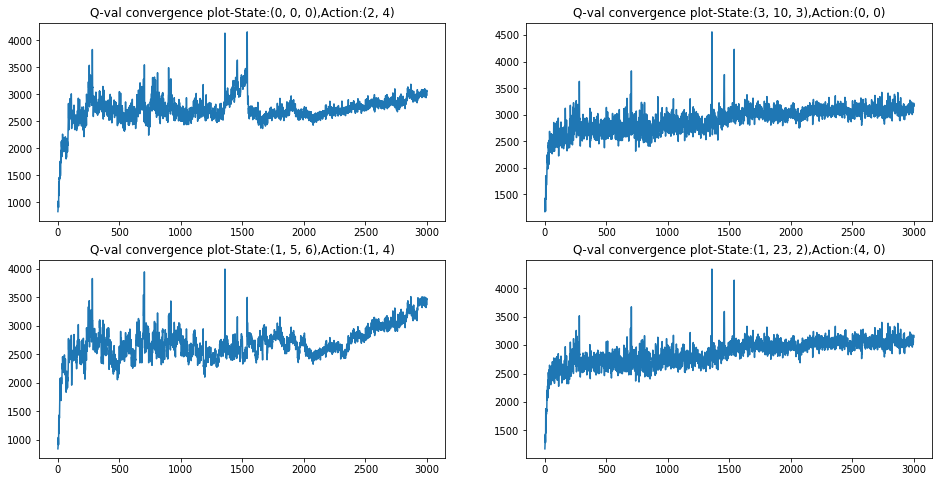

In [10]:
plt.figure(0, figsize=(16,8))
subplotsList = [221, 222, 223, 224]
i=0
for state, action, state_str in states_to_be_tracked:
    plt.subplot(subplotsList[i])
    plot_convergence(state, action, state_str, i)
    i=i+1

### Tracking Rewards per episode

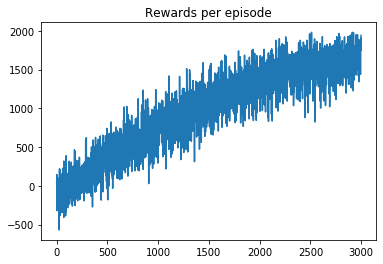

In [11]:
x_axis = np.asarray(range(0, len(episode_reward_track)))
plt.plot(x_axis,np.asarray(episode_reward_track))
plt.title("Rewards per episode")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [12]:
time = np.arange(0,30000)
epsilon = []
for i in range(0,30000):
    epsilon.append(0 + (1 - 0.001) * np.exp(-0.00008*i))

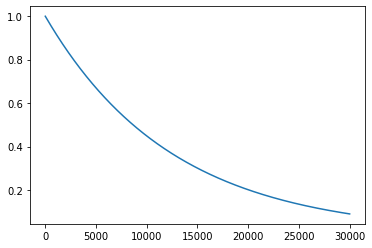

In [13]:
plt.plot(time, epsilon)
plt.show()